<a href="https://www.kaggle.com/code/neuralsrg/speech-reconstruction?scriptVersionId=136126472" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Ideas

### Artefact removal

* https://www.intechopen.com/chapters/74032
* https://medium.com/@nikeshbajaj/artifacts-in-eeg-and-how-to-remove-them-atar-algorithm-ica-fbb91ea8485a

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import glob
import regex
from typing import Dict, List, Tuple, Union

import tqdm.notebook as tqdm

import numpy as np
import math
import pandas as pd

from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

import librosa
import torchaudio

import matplotlib_inline
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from IPython.display import display, Audio, Markdown

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [21]:
base = '/kaggle/input/internal-speech-recognition/Vartanov/audios'

A = "A.wav"
B = "B.wav"
F = "F.wav"
G = "G.wav"
M = "M.wav"
R = "R.wav"
U = "U.wav"

Ba = "Ba.wav"
Bu = "Bu.wav"
Fa = "Fa.wav"
Fu = "Fu.wav"
Ga = "Ga.wav"
Gu = "Gu.wav"
Ma = "Ma.wav"
Mu = "Mu.wav"
Ra = "Ra.wav"
Ru = "Ru.wav"

Biblioteka = "St1.wav"
Raketa = "St2.wav"
Kurier = "St3.wav"
Ograda = "St4.wav"
Haketa = "St5.wav"

phonemes_m3_labels = {
    12: os.path.join(base, "phonemes", A),
    22: os.path.join(base, "phonemes", A),
    13: os.path.join(base, "phonemes", B),
    23: os.path.join(base, "phonemes", B),
    14: os.path.join(base, "phonemes", F),
    24: os.path.join(base, "phonemes", F),
    15: os.path.join(base, "phonemes", G),
    25: os.path.join(base, "phonemes", G),
    16: os.path.join(base, "phonemes", M),
    26: os.path.join(base, "phonemes", M),
    17: os.path.join(base, "phonemes", R),
    27: os.path.join(base, "phonemes", R),
    18: os.path.join(base, "phonemes", U),
    28: os.path.join(base, "phonemes", U)
}

phonemes_m4_labels = {
    1: os.path.join(base, "phonemes", A),
    11: os.path.join(base, "phonemes", A),
    2: os.path.join(base, "phonemes", B),
    12: os.path.join(base, "phonemes", B),
    3: os.path.join(base, "phonemes", F),
    13: os.path.join(base, "phonemes", F),
    4: os.path.join(base, "phonemes", G),
    14: os.path.join(base, "phonemes", G),
    5: os.path.join(base, "phonemes", M),
    15: os.path.join(base, "phonemes", M),
    6: os.path.join(base, "phonemes", R),
    16: os.path.join(base, "phonemes", R),
    7: os.path.join(base, "phonemes", U),
    17: os.path.join(base, "phonemes", U)
}

syllables_labels = {
    1: os.path.join(base, "syllables", Ba),
    11: os.path.join(base, "syllables", Ba),
    2: os.path.join(base, "syllables", Fa),
    12: os.path.join(base, "syllables", Fa),
    3: os.path.join(base, "syllables", Ga),
    13: os.path.join(base, "syllables", Ga),
    4: os.path.join(base, "syllables", Ma),
    14: os.path.join(base, "syllables", Ma),
    5: os.path.join(base, "syllables", Ra),
    15: os.path.join(base, "syllables", Ra),
    6: os.path.join(base, "syllables", Bu),
    16: os.path.join(base, "syllables", Bu),
    7: os.path.join(base, "syllables", Ru),
    17: os.path.join(base, "syllables", Ru),
    8: os.path.join(base, "syllables", Mu),
    18: os.path.join(base, "syllables", Mu),
    9: os.path.join(base, "syllables", Fu),
    19: os.path.join(base, "syllables", Fu),
    10: os.path.join(base, "syllables", Gu),
    20: os.path.join(base, "syllables", Gu)
}

words_labels = {
    11: os.path.join(base, "words", Biblioteka),
    21: os.path.join(base, "words", Biblioteka),
    12: os.path.join(base, "words", Raketa),
    22: os.path.join(base, "words", Raketa),
    13: os.path.join(base, "words", Kurier),
    23: os.path.join(base, "words", Kurier),
    14: os.path.join(base, "words", Ograda),
    24: os.path.join(base, "words", Ograda),
    15: os.path.join(base, "words", Haketa),
    25: os.path.join(base, "words", Haketa)
}

audio_map = {
    "syllables": syllables_labels,
    "phonemes_m3": phonemes_m3_labels,
    "phonemes_m4": phonemes_m4_labels,
    "words": words_labels
}

In [22]:
config = {
    'sound_size': 50432,
    'sound_frame_size': 1024,
    'sound_hop': 256,
    'shift_bounds': (-5, 5),
    'sigma': 0.005,
    'n_components': 40,
    'path': '/kaggle/input/internal-speech-recognition/Vartanov/feather',
    'audio_maps': audio_map,
    'sample_rate': 44100,
    'eeg_sr': 1006,
    'fragment_length': 2012,
    
    # model parameters
    'input_size': 64,
    'encoder_hidden_size': 512, 
    'decoder_hidden_size': 512,
    'n_audio_frames': 194,
    'encoder_dropout': .2,
    'decoder_dropout': .2
}

In [23]:
sections = ["syllables", "phonemes_m3", "phonemes_m4", "words"]

# Torch Dataset

In [30]:
class EEGDataset(Dataset):
    def __init__(self, path: str, audio_maps: dict, fragment_length: int = 2012, partition_size: int = 32,
                 sample_rate: int = 44100, sound_channel: int = 1):
        '''
        path: path to sections (folders)
        audio_maps: two-level map: section names -> labels -> audio_paths
        fragment_lengtht: length of fragment after label
        partition_size: number of nonzero labels in each csv file
        '''
        super().__init__()
        self.sections = sorted(os.listdir(path))
        assert set(self.sections) == set(audio_maps.keys()), "Sections must be the same!"
        self.audio_maps = audio_maps 
        self.paths = [[os.path.join(path, sec, file) for file in sorted(os.listdir(os.path.join(path, sec)))] for sec in self.sections]
        self.sec_num_files = [len(elem) for elem in self.paths]
        self.sec_cumnum = np.cumsum(self.sec_num_files) * partition_size
        self.total_num_files = sum(self.sec_num_files)
        self.partition_size = partition_size
        self.fragment_length = fragment_length
        self.sr = sample_rate
        self.sound_channel = sound_channel
        
    def __len__(self) -> int:
        return self.total_num_files * self.partition_size
    
    def to_section(self, idx):
        section = np.where(idx < self.sec_cumnum)[0][0]
        section_idx = idx if (section == 0) else (idx - self.sec_cumnum[section - 1])
        return section, section_idx
    
    def get_audio(self, section, label):
        section_name = self.sections[section]
        audio, current_sr = torchaudio.load(self.audio_maps[section_name][label])
        audio = torchaudio.functional.resample(audio, orig_freq=current_sr, new_freq=self.sr)
        return audio[self.sound_channel]
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        '''
        int idx: file ID
        return: EEG fragment with its corresponding audio
        '''
        section, section_idx = self.to_section(idx)
        file_path = self.paths[section][section_idx // self.partition_size]
        
        start = (section_idx % self.partition_size) * self.fragment_length
        end = start + self.fragment_length
        
        data = pd.read_feather(file_path).to_numpy()
        x, label = torch.tensor(data[start:end, 1:]), data[start, 0].astype(int)
        # x, label = torch.tensor(data[:, 1:]), data[0, 0].astype(int)
        
        audio = self.get_audio(section, label)
        return x, audio

In [31]:
dataset = EEGDataset(path=config['path'], audio_maps=config['audio_maps'])

In [9]:
dataset.sec_cumnum

array([ 3904,  8096, 19040, 26240])

In [10]:
x, audio = dataset[0]
Audio(audio, rate=dataset.sr)

In [21]:
x, audio = dataset[4192]
Audio(audio, rate=dataset.sr)

In [23]:
x, audio = dataset[8096]
Audio(audio, rate=dataset.sr)

In [24]:
x, audio = dataset[15296]
Audio(audio, rate=dataset.sr)

In [55]:
class STFTTransformer:
    
    def __init__(self, sound_frame_size: int, sound_hop: int):
        """
        :param int sound_frame_size: frame_size parameter for sound STFT
        :param int sound_hop: hop_length parameter for sound STFT
        """
        self.sound_frame_size = sound_frame_size
        self.sound_hop = sound_hop
    
    def transform(self, audio: torch.tensor) -> torch.tensor:
        """
        Computes STFT of a given audio
        
        :param torch.tensor audio: audio to compute STFT of
        :return: STFT of a given audio
        :rtype: torch.tensor
        """
        
        spec = torch.stft(audio, n_fft=self.sound_frame_size, hop_length=self.sound_hop,
                          return_complex=True, center=False)
        return torch.abs(spec)
    
    @staticmethod
    def restore(D: np.array, frame_size: int, hop_length: int, epochs: int = 10, window: str = 'hann'):
        
        D = np.concatenate((np.zeros((D.shape[0], 1)), D, np.zeros((D.shape[0], 1))), axis=1)
        mag, _ = librosa.magphase(D)
        phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=mag.shape))
        x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)

        for i in range(epochs):
            _, phase = librosa.magphase(librosa.stft(x_, n_fft=frame_size, hop_length=hop_length, center=False,
                                                     window=window))
            x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, window=window)

        return x_[hop_length:-hop_length]
    
    def inverse_transform(self, spec: torch.tensor):
        """
        Transforms spectrum bach to sound
        :param torch.tensor spec: spectrum to transform
        :return: Sound
        :rtype: torch.tensor
        """
        return torch.tensor(STFTTransformer.restore(spec.detach().cpu().numpy(), 
                                                    frame_size=self.sound_frame_size,
                                                    hop_length=self.sound_hop))
        

class EncodedDataset(Dataset):
    
    def __init__(self, eeg_sr: int, sound_size: int, sound_frame_size: int, sound_hop: int,
                 shift_bounds: Tuple[int, int], sigma: float, 
                 n_components: int, **kwargs):
        """
        EEG patams:
        :param int eeg_sr: EEG sampling rate
        
        Sound STFT:
        :param int sound_size: Size of the entire sound signal that is mapped to EEG
        :param int sound_frame_size: frame_size parameter for sound STFT
        :param int sound_hop: hop_length parameter for sound STFT
        
        Adding noise to the sound signal:
        :param Tuple[int, int] shift_bounds: Bounds for the uniform distribution of a random shift
        :param float sigma: std of a random noise
        
        EEGDataset parameters:
        :param dict kwargs: EEGDataset parameters
        
        PCA parameters:
        :param int n_components: Number of components used in PCA
        """
        
        # main dataset
        self.eeg_dataset = EEGDataset(**kwargs)
        
        # STFT params
        self.sound_size = sound_size
        self.stft_transformer = STFTTransformer(sound_frame_size, sound_hop)
        
        # Audio params
        self.sound_channel = kwargs.get('sound_channel', 1)
        self.sr = kwargs.get('sample_rate', 44100)
        
        # EEG params
        self.eeg_sr = eeg_sr
        
        # Noise params
        self.shift_bounds = shift_bounds
        self.sigma = sigma
        
        # PCA
        self.pca_transformer = PCA(n_components)
        self.fit_pca()
        
    def fit_pca(self):
        """
        Fits PCA transformer
        """
        
        # all sound files
        files = []
        for _, outer_dict in audio_map.items():
            for _, filename in outer_dict.items():
                files.append(filename)
        files = np.unique(files)
        
        # read sound files
        sounds = []
        for filename in files:   
            audio, current_sr = torchaudio.load(filename)
            audio = torchaudio.functional.resample(audio, orig_freq=current_sr, new_freq=self.sr)
            sounds.append(audio[self.sound_channel])
        sounds = torch.cat(sounds, dim=0)
        
        # STFT
        spectrum = self.stft_transformer.transform(sounds)
        
        # fit PCA
        self.pca_transformer.fit(spectrum.t())
        
    def restore_audio(self, projected_spectrum: torch.tensor) -> torch.tensor:
        """
        Restores audio given projected spectrum
        :param torch.tensor projected_spectrum: spectrum projection
        :return Restored audio
        :rtype: torch.tensor
        """
        spec = projected_spectrum @ self.pca_transformer.components_ + self.pca_transformer.mean_[None, :]
        # print('restored spec shape', spec.size())
        return self.stft_transformer.inverse_transform(spec.t())
        
    def __len__(self):
        return len(self.eeg_dataset)
    
    def __getitem__(self, idx: int) -> Dict:
        """
        :param int idx: Index
        :return: Dictionary:
            'eeg': torch.tensor
            'sound': torch.tensor
            'spectrum': torch.tensor
        :rtype: Dict
        """
        
        signal, audio = self.eeg_dataset.__getitem__(idx)
        signal = signal[:int(self.sound_size / self.sr * self.eeg_sr)]
        
        pad_size = self.sound_size - audio.size(0)
        audio = torch.nn.functional.pad(audio, (0, pad_size), value=0)
        
        # noise
        shift = torch.FloatTensor(1).uniform_(self.shift_bounds[0], self.shift_bounds[1]+1).int().item()
        audio = torch.nn.functional.pad(audio, (shift, -shift), value=0)
        audio += torch.FloatTensor(*audio.size()).normal_(0, self.sigma)
        
        # project sound spectrum
        spectrum = self.stft_transformer.transform(audio)
        projected_spectrum = torch.tensor(self.pca_transformer.transform(spectrum.t()))
        
        return {
            'eeg': signal,
            'audio': audio,
          #  'pr': projected_spectrum
        }

In [57]:
train_ds = EncodedDataset(sound_size=config['sound_size'], sound_frame_size=config['sound_frame_size'],
                          sound_hop=config['sound_hop'], shift_bounds=config['shift_bounds'],
                          sigma=config['sigma'], n_components=config['n_components'],
                          path=config['path'], audio_maps=config['audio_maps'],
                          sample_rate=config['sample_rate'], fragment_length=config['fragment_length'],
                          eeg_sr=config['eeg_sr'])
# train_ds, val_ds = torch.utils.data.random_split(train_ds, [0.9, 0.1])

In [58]:
%%time
for i in tqdm.tqdm(range(256)):
    train_ds[i]

  0%|          | 0/256 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
def collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    data = {}
    data['eeg'] = torch.stack([elem['eeg'] for elem in batch])
    data['audio'] = torch.stack([elem['audio'] for elem in batch])
    data['pr'] = torch.stack([elem['pr'] for elem in batch])
    return data

train_dl = DataLoader(train_ds, 16, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, 16, shuffle=False, collate_fn=collate_fn)

In [43]:
%%time
next(iter(train_dl))

CPU times: user 1min 1s, sys: 5.22 s, total: 1min 6s
Wall time: 1min 11s


{'eeg': tensor([[[-3.0631e+00, -6.1222e+00, -1.3558e+01,  ...,  1.2259e+01,
            9.2065e+00,  7.7761e+00],
          [-3.3797e+00, -6.7781e+00, -1.2876e+01,  ...,  1.2740e+01,
            9.3866e+00,  8.0648e+00],
          [-3.7123e+00, -7.6791e+00, -1.2876e+01,  ...,  1.3879e+01,
            1.0279e+01,  9.1493e+00],
          ...,
          [ 2.7222e-01,  9.7236e-01,  3.2188e+00,  ..., -7.1845e-01,
           -1.2752e+00, -2.3253e+00],
          [ 1.9665e-01,  8.7635e-01,  3.3087e+00,  ..., -2.9600e-01,
           -1.0943e+00, -2.1230e+00],
          [ 5.3115e-03,  2.8045e-01,  2.4036e+00,  ...,  1.9505e-03,
           -2.5164e-01, -1.3716e+00]],
 
         [[-7.0581e+00, -1.8645e+01, -3.4005e-01,  ..., -3.8205e+00,
            2.6983e+00, -4.8890e-01],
          [-7.2849e+00, -1.9288e+01, -5.3385e-01,  ..., -4.2079e+00,
            1.7658e+00, -1.3738e+00],
          [-7.2445e+00, -1.9450e+01, -7.5239e-01,  ..., -4.8929e+00,
            7.3160e-01, -2.3429e+00],
          ..

In [122]:
# print('entire window', 44100 * 0.02)
print('time frames', (50432 - 1024) / 256 + 1)
print('modified window', (194 - 1) * 256 + 1024)

time frames 194.0
modified window 50432


In [18]:
len(train_ds)

26240

In [25]:
elem = train_ds[8096]

audio = train_ds.restore_audio(elem['pr'])
Audio(audio, rate=dataset.sr)

In [37]:
print(elem['eeg'].shape)
print(elem['audio'].shape)
print(elem['pr'].shape)

torch.Size([1150, 63])
torch.Size([50432])
torch.Size([194, 40])


In [38]:
1150 / 1006, 50432 / 44100

(1.143141153081511, 1.1435827664399092)

# Model

In [ ]:
class LSTMNet(torch.nn.Module):
    
    def __init__(self, input_size: int, encoder_hidden_size: int, decoder_hidden_size: int,
                 n_audio_frames: int, n_components: int, encoder_dropout: float, decoder_dropout: float):
        super().__init__()
        self.encoder = torch.nn.LSTM(input_size=input_size, hidden_size=encoder_hidden_size, 
                                     batch_first=True, dropout=encoder_dropout)
        self.decoder = torch.nn.LSTM(input_size=encoder_hidden_size, hidden_size=decoder_hidden_size, 
                                     batch_first=True, dropout=decoder_dropout)
        self.n_audio_frames = n_audio_frames
        self.decoder_hidden_size = decoder_hidden_size
        self.fc = torch.nn.Linear(decoder_hidden_size, n_components)
        
    def forward(self, x: torch.tensor):
        """
        :param torch.tensor x: Tensor of shape (batch, sequence_length, input_size)
        """
        out, _ = self.encoder(x)  # out: (batch, sequence_length, encoder_hidden_size)
        out = out[:, -1, :].unsqueeze(1)  # (batch, 1, encoder_hidden_size)
        
        h, c = None, None
        hs = torch.zeros((out.size(0), self.n_audio_frames, self.decoder_hidden_size))
        for i in range(self.n_audio_frames):
            out, (h, c) = self.decoder(out, (h, c))  # out: (batch, 1, decoder_hidden_size)
            hs[:, i, :] = out
            
        out = self.fc(out)  # (batch, n_audio_frames, n_components)
        return out

# Train

In [ ]:
model_checkpoint_path = os.path.join(os.getcwd(), 'model_checkpoints')

if not os.path.exists(model_checkpoint_path):
    os.mkdir(model_checkpoint_path)
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LSTMNet(
    input_size=config['input_size'],
    encoder_hidden_size=config['encoder_hidden_size'], 
    decoder_hidden_size=config['decoder_hidden_size'],
    n_audio_frames=config['n_audio_frames'],
    n_components=config['n_components'],
    encoder_dropout=config['encoder_dropout'],
    decoder_dropout=config['decoder_dropout']
).to(device).train()

criterion = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)

current_lr = scheduler.get_last_lr()[-1]
max_norm = 1.0

hist = []

In [ ]:
total_step = 0

train_loss = []
val_loss = 0
grad_norm = []

for epoch in tqdm.tqdm(range(n_epochs)):

    for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

        total_step += 1

        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to device
        x, y = batch['eeg'].to(device), batch['pr'].to(device)

        # Perform forward pass
        y_pred = model(x)
        loss = criterion(y_pred, y)

        # Perform backward pass
        loss.backward()

        # Averaging over sliding window
        if len(train_loss) < 100:
            train_loss.append(loss.item())
            # Perform Gradient Clipping
            grad_norm.append(torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm).item())
        else:
            train_loss[(total_step - 1) % 100] = loss.item()
            grad_norm[(total_step - 1) % 100] = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm).item()

        # Perform Optimization Step
        optimizer.step()
        
        # Perform Scheduler Step
        scheduler.step()
        current_lr = scheduler.get_last_lr()[-1]

    # validation
    val_loss = 0
    model.eval()

    with torch.no_grad():
        for val_batch in val_dl:
            x, y = val_batch['eeg'].to(device), val_batch['pr'].to(device)
            y_pred = model(x)
            val_loss += criterion(y_pred, y).item()

        val_loss /= len(val_dl)

        # saving logs
        writer.add_scalar('Loss/Val', val_loss, global_step=total_step)

    model.train()

        # update tqdm info
        pbar.set_description(
            'Lr: {0:.2e}, GradNorm: {1:.2e}, Train Loss: {2:.2e}, Val Loss: {3:.3f}'.format(
                current_lr, np.mean(grad_norm), np.mean(train_loss), val_loss
            )
        )

        # saving logs
        writer.add_scalar('Loss/Train', np.mean(train_loss), global_step=total_step)
        writer.add_scalar('GradNorm', np.mean(grad_norm), global_step=total_step)
    
    # saving model
    torch.save(model.state_dict(), os.path.join(model_checkpoint_path, f'sb_encoder-{epoch}.pth'))

    writer.flush()

In [32]:
a = np.random.rand(26240, 2000, 64)
a.shape

(26240, 2000, 64)

In [33]:
dataset[896]

(tensor([[  0.5628,  16.9743,   2.4409,  ..., -68.4867, -50.5621, -57.5490],
         [  0.4713,  17.6385,   2.8874,  ..., -69.5511, -51.3722, -58.0489],
         [  0.3315,  17.8560,   3.3009,  ..., -69.9724, -51.8785, -58.3098],
         ...,
         [ -2.4117, -13.7218,  -8.1783,  ...,   4.7259,  -4.4135,  -8.5136],
         [ -2.3911, -11.0147,  -4.5721,  ...,  -1.0220,  -9.1544, -13.1095],
         [ -2.3564,  -8.8711,  -1.9019,  ...,  -6.1769, -13.1641, -17.0900]],
        dtype=torch.float64),
 tensor([-0.0003, -0.0005, -0.0003,  ...,  0.0112,  0.0114,  0.0051]))

In [38]:
dataset[896]

(tensor([[ -0.0815,  -0.2327,  -0.1390,  ...,  -7.8471,  -6.4027,  -6.0767],
         [ -0.0679,  -0.2379,  -0.1679,  ...,  -7.9606,  -7.0239,  -6.7132],
         [ -0.0552,  -0.3475,  -0.1904,  ...,  -9.1591,  -8.2091,  -7.8282],
         ...,
         [ -0.6616,   2.4228,  -0.5473,  ..., -40.0096, -36.5305, -34.7441],
         [ -0.6100,   2.1917,  -0.5204,  ..., -38.4878, -35.4451, -33.7286],
         [ -0.5851,   2.1306,  -0.5011,  ..., -37.9598, -35.2901, -33.5702]],
        dtype=torch.float64),
 tensor([-8.4686e-26, -8.4686e-26, -8.4686e-26,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]))

In [25]:
dataset[896]

(tensor([[ -0.0815,  -0.2327,  -0.1390,  ...,  -7.8471,  -6.4027,  -6.0767],
         [ -0.0679,  -0.2379,  -0.1679,  ...,  -7.9606,  -7.0239,  -6.7132],
         [ -0.0552,  -0.3475,  -0.1904,  ...,  -9.1591,  -8.2091,  -7.8282],
         ...,
         [ -0.6616,   2.4228,  -0.5473,  ..., -40.0096, -36.5305, -34.7441],
         [ -0.6100,   2.1917,  -0.5204,  ..., -38.4878, -35.4451, -33.7286],
         [ -0.5851,   2.1306,  -0.5011,  ..., -37.9598, -35.2901, -33.5702]],
        dtype=torch.float64),
 tensor([-8.4686e-26, -8.4686e-26, -8.4686e-26,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]))

# Experiments

In [18]:
! rm -rf /kaggle/working/PyTorchWavelets

In [9]:
! git clone https://github.com/neuralsrg/PyTorchWavelets.git
# ! pip install -r /kaggle/working/PyTorchWavelets/requirements.txt
# ! python /kaggle/working/PyTorchWavelets/setup.py install

Cloning into 'PyTorchWavelets'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 107 (delta 1), reused 2 (delta 0), pack-reused 102
Receiving objects: 100% (107/107), 1.07 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (50/50), done.
running install
/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating wavelets_pytorch.egg-info
writing wavelets_pytorch.egg-info/PKG-INFO
writing dependency_links to wavelets_pytorch.egg-info/dependency_links.txt
writing top-level names to wavelets_pytorch.

In [4]:
! ls /kaggle/working/PyTorchWavelets

README.md  examples	requirements.txt  wavelets_pytorch
assets	   license.txt	setup.py


In [10]:
import sys
sys.path.append('/kaggle/working/PyTorchWavelets/')
from wavelets_pytorch.transform import WaveletTransformTorch

In [11]:
import numpy as np
from wavelets_pytorch.transform import WaveletTransform        # SciPy version
from wavelets_pytorch.transform import WaveletTransformTorch   # PyTorch version

from wavelets_pytorch.wavelets import Morlet, Ricker

"""
Example script to demonstrate the CWT on a batch of random sinusoidal signals. 
We compare both the SciPy implementation and the PyTorch implementation. 
"""

dt = 0.1               # sampling frequency
dj = 0.8               # scale distribution parameter
batch_size = 32        # how many signals to process in parallel
cuda = torch.cuda.is_available()            # enable GPU

t = np.linspace(0., 10., int(10./dt))

wavelet = Morlet()

# Sinusoidals with random frequency
frequencies = np.random.uniform(-0.5, 2.0, size=batch_size)
batch = np.asarray([np.sin(2*np.pi*f*t) for f in frequencies])

# Initialize wavelet filter banks (scipy and torch implementation)
wa_scipy = WaveletTransform(dt, dj, wavelet)
wa_torch = WaveletTransformTorch(dt, dj, wavelet, cuda=cuda)

# Performing wavelet transform (and compute scalogram)
print(f'batch shape: {batch.shape}')
cwt_scipy = wa_scipy.cwt(batch)
cwt_torch = wa_torch.cwt(batch)

print(cwt_scipy.shape)
print(cwt_torch.shape)

batch shape: (32, 100)
(32, 8, 100)
(32, 8, 100)


In [12]:
wa_scipy.scales

array([0.19360266, 0.33708181, 0.58689352, 1.02184098, 1.77912847,
       3.09764259, 5.393309  , 9.39029638])

In [19]:
0.19360266 * 2 ** 0.8

0.337081809437256

In [38]:
wa_scipy._filters[0].shape

(19,)

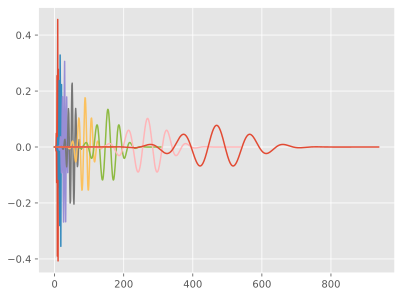

In [13]:
for f in wa_scipy._filters:
    plt.plot(f.real)

In [17]:

sampling_period = dt


In [18]:
Ms = [10 * scale / wa_scipy.dt for scale in wa_scipy.scales]
w = 6
[2*s*w*sampling_period / M for s, M in zip(wa_scipy.scales, Ms)]

[0.012,
 0.012,
 0.012000000000000002,
 0.012,
 0.011999999999999999,
 0.012,
 0.012000000000000002,
 0.012]